# Seminar #1. Anomaly detection
![](https://i1.wp.com/thedatascientist.com/wp-content/uploads/2019/02/anomaly_detection.png?fit=1024%2C683&ssl=1)

## Two mindsets for anomaly detection:

- When all you need is clean data, so you want to get rid of the anomalous data points. Often in cases where you have manual data input.

Example:

the technician was manually logging room temperature
```
room_temperature = [24.5, 23.2, 23.5, 22.9, 230, 23.2]
```
- When anomalies are points of interest and you want to detect anomalies for further action

Examples:
* Equipment failure
* Malicious activity in the network
* Fraud detection



## Case study: Readings from the field sensor during well-testing
![](https://thumbs.gfycat.com/MajorForcefulFossa-size_restricted.gif)

In [3]:
%pylab inline 
%load_ext autoreload
%autoreload 2

# external
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


# Case 1: Surface sampling and well-testing

In [4]:
data = pd.read_csv("../data/ASD_signal.csv")
data.index = pd.to_datetime(data['Date & Time'])

In [5]:
data.iloc[0].T

Date & Time              3/27/2018 0:05
qo_lc[m3/d]                      335.07
qw_lc[m3/d]                      5.7946
qg_lc[m3/d]                       14387
qo_sc[Sm3/d]                     246.36
qw_sc[Sm3/d]                     5.7752
qg_sc[Sm3/d]                     811000
qo_scnp[Sm3/d]                   246.36
qw_scnp[Sm3/d]                   5.7752
qg_scnp[Sm3/d]                   783000
Fo_lc[%]                          2.747
Fw_lc[%]                       0.047506
Fg_lc[%]                         97.206
WLR[%]                              1.7
GVF[%]                           97.676
GLR[m3/m3]                       43.198
BSW[%]                           2.2906
GOR[Sm3/Sm3]                     3368.6
GOR1[Sm3/Sm3]                    3254.2
mo_lc[kg/d]                      238000
mw_lc[kg/d]                      5769.4
mg_lc[kg/d]                      620000
m_lc[kg/d]                       860000
mo_sc[kg/d]                      195000
mw_sc[kg/d]                      5780.3


Text(0, 0.5, 'Pressure [bara]')

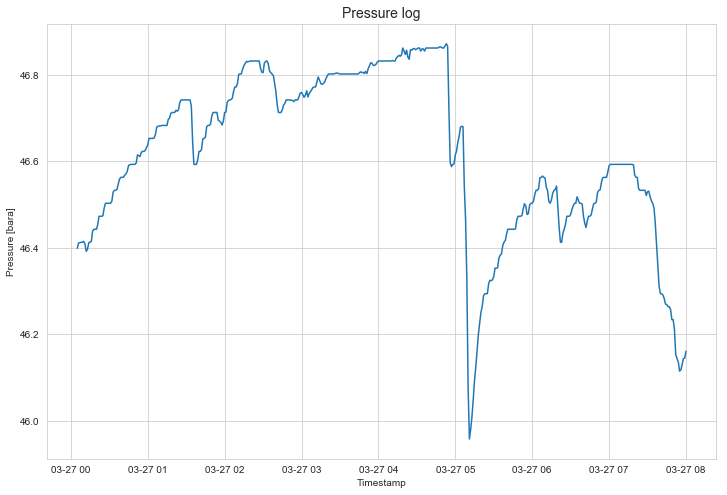

In [6]:
pylab.figure(figsize=(12,8))
pylab.title("Pressure log", size=14)
pylab.plot(data['POUT[bara]'])
pylab.xlabel('Timestamp')
pylab.ylabel('Pressure [bara]')

Text(0, 0.5, '% change')

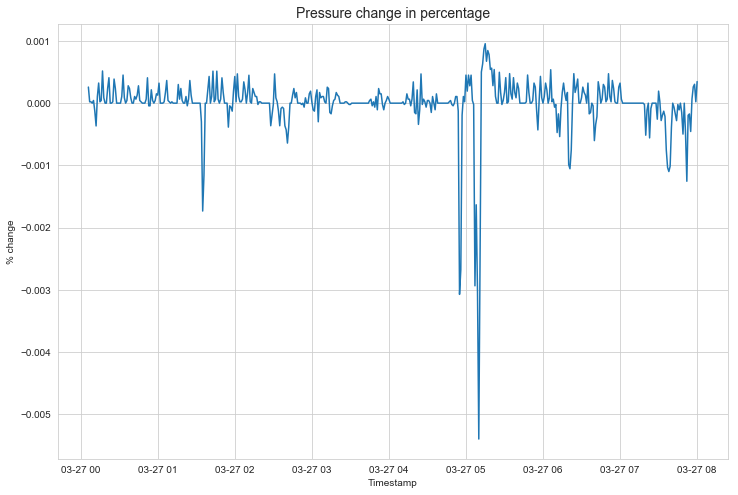

In [7]:
pylab.figure(figsize=(12,8))
pylab.title("Pressure change in percentage", size=14)
pylab.plot(data['POUT[bara]'].pct_change())
pylab.xlabel('Timestamp')
pylab.ylabel('% change')

# Z-score:

$\begin{equation*}\large
z-score = \frac{x - \mu}{\sigma} 
\end{equation*}$


In [8]:
data['POUT_pct_change'] = data['POUT[bara]'].pct_change().fillna(0)

mu = data['POUT_pct_change'].mean()
sigma = data['POUT_pct_change'].std()

data['POUT_z_score'] = data['POUT_pct_change'].apply(lambda x: (x-mu)/sigma)

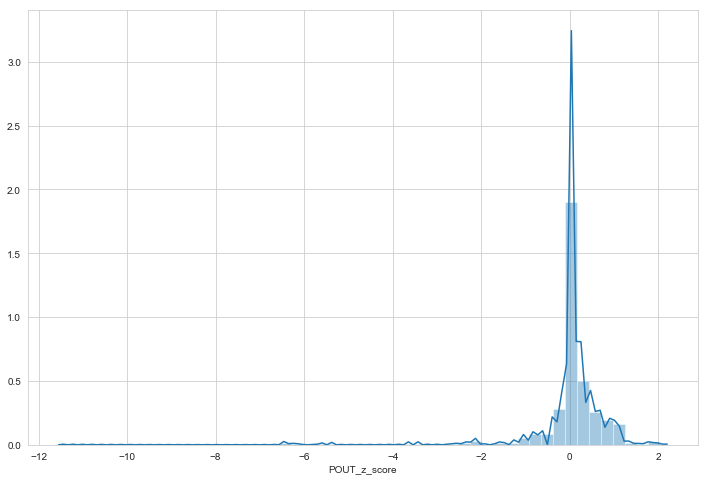

In [9]:
pylab.figure(figsize=(12,8))
sns.distplot(data['POUT_z_score'])

Text(0, 0.5, 'pct change')

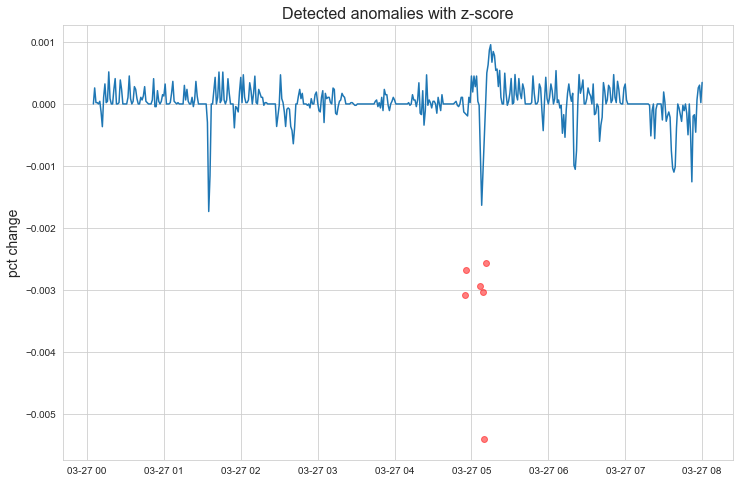

In [265]:
threshold = -4 # z-score threshold

pylab.figure(figsize=(12,8))
pylab.title("Detected anomalies with z-score", size=16)
pylab.plot(data[data['POUT_z_score']>threshold]['POUT_pct_change'])
pylab.scatter(data[data['POUT_z_score']<threshold]['POUT_pct_change'].index,
              data[data['POUT_z_score']<threshold]['POUT_pct_change'],
              color='r', 
              alpha=0.5)
pylab.ylabel('pct change', size=14)

Text(0, 0.5, 'Pressure [bara]')

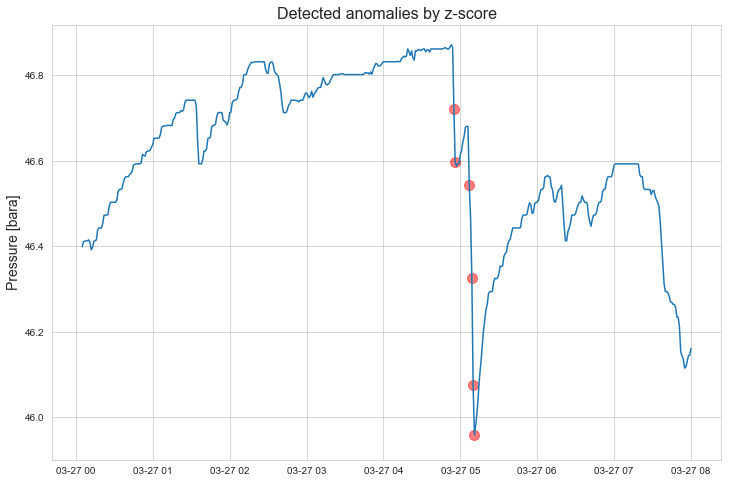

In [266]:
threshold = -4 # z-score threshold

pylab.figure(figsize=(12,8))
pylab.title("Detected anomalies by z-score", size=16)
pylab.plot(data[data['POUT[bara]']>threshold]['POUT[bara]'])
pylab.scatter(data[data['POUT_z_score']<threshold].index,
              data[data['POUT_z_score']<threshold]['POUT[bara]'],
              color='r', 
              alpha=0.5,
              s=100
             )
pylab.ylabel("Pressure [bara]", size=14)

In [267]:
data['anomaly_by_z_score'] = data['POUT_z_score'].apply(lambda x: 1 if x<threshold else 0)

## Anomalous timestamps

In [268]:
data[data['anomaly_by_z_score']==1]['Date & Time'].index

DatetimeIndex(['2018-03-27 04:55:00', '2018-03-27 04:56:00',
               '2018-03-27 05:07:00', '2018-03-27 05:09:00',
               '2018-03-27 05:10:00', '2018-03-27 05:11:00'],
              dtype='datetime64[ns]', name='Date & Time', freq=None)

---

## Local outlier factor

It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.

source: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_lof_outlier_detection_001.png)

source: https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html#sphx-glr-auto-examples-neighbors-plot-lof-outlier-detection-py

In [217]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outliers = lof.fit_predict(data['POUT_pct_change'].values.reshape(-1,1))

In [218]:
data['anomaly_by_lof'] = outliers

Text(0, 0.5, 'pct change')

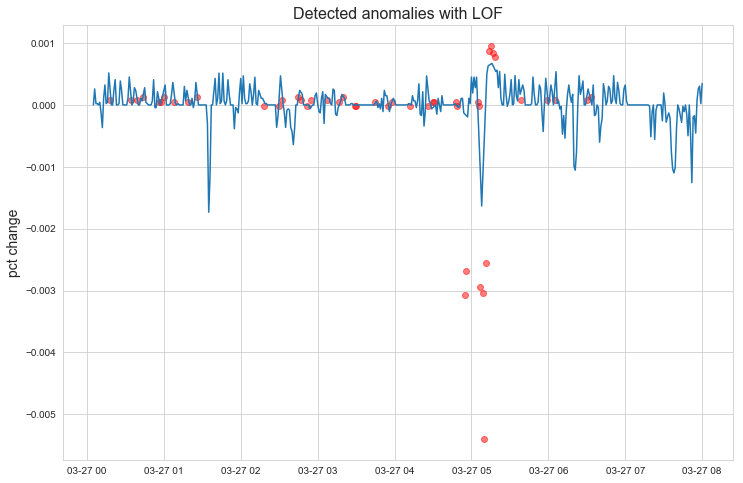

In [219]:
pylab.figure(figsize=(12,8))
pylab.title("Detected anomalies with LOF", size=16)
pylab.plot(data[data['anomaly_by_lof']==1]['POUT_pct_change'])
pylab.scatter(data[data['anomaly_by_lof']==-1]['POUT_pct_change'].index,
              data[data['anomaly_by_lof']==-1]['POUT_pct_change'],
              color='r', 
              alpha=0.5)
pylab.ylabel('pct change', size=14)

Text(0, 0.5, 'Pressure [bara]')

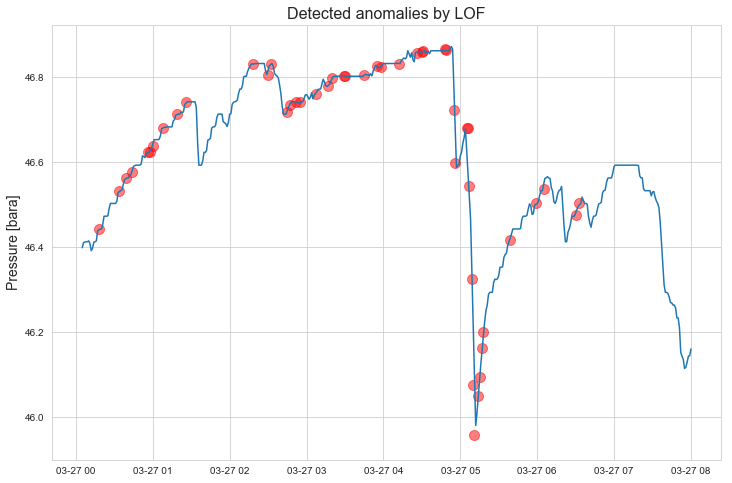

In [238]:
pylab.figure(figsize=(12,8))
pylab.title("Detected anomalies by LOF", size=16)
pylab.plot(data[data['anomaly_by_lof']==1]['POUT[bara]'])
pylab.scatter(data[data['anomaly_by_lof']==-1].index,
              data[data['anomaly_by_lof']==-1]['POUT[bara]'],
              color='r', 
              alpha=0.5,
              s=100
             )
pylab.ylabel("Pressure [bara]", size=14)

---

## Isolation Forest

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_isolation_forest_001.png)

source:
https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py

In [248]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(contamination=0.03)
outliers = iforest.fit_predict(data['POUT_pct_change'].values.reshape(-1,1))

In [249]:
data['anomaly_by_iforest'] = outliers

Text(0, 0.5, 'pct change')

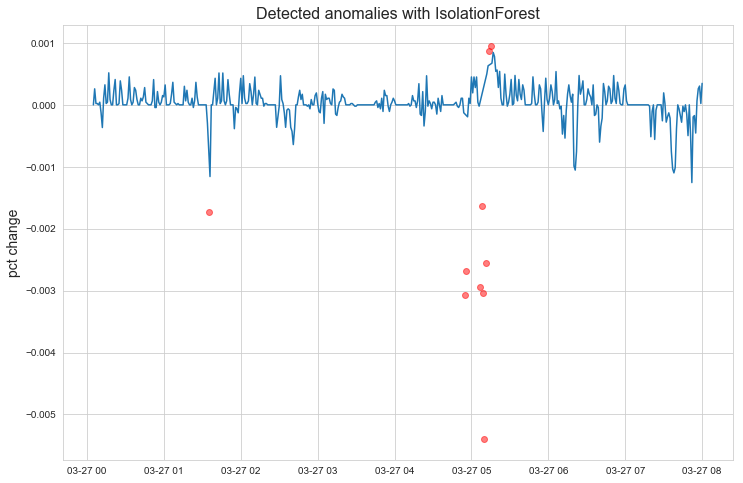

In [250]:
pylab.figure(figsize=(12,8))
pylab.title("Detected anomalies with IsolationForest", size=16)
pylab.plot(data[data['anomaly_by_iforest']==1]['POUT_pct_change'])
pylab.scatter(data[data['anomaly_by_iforest']==-1]['POUT_pct_change'].index,
              data[data['anomaly_by_iforest']==-1]['POUT_pct_change'],
              color='r', 
              alpha=0.5)
pylab.ylabel('pct change', size=14)

Text(0, 0.5, 'Pressure [bara]')

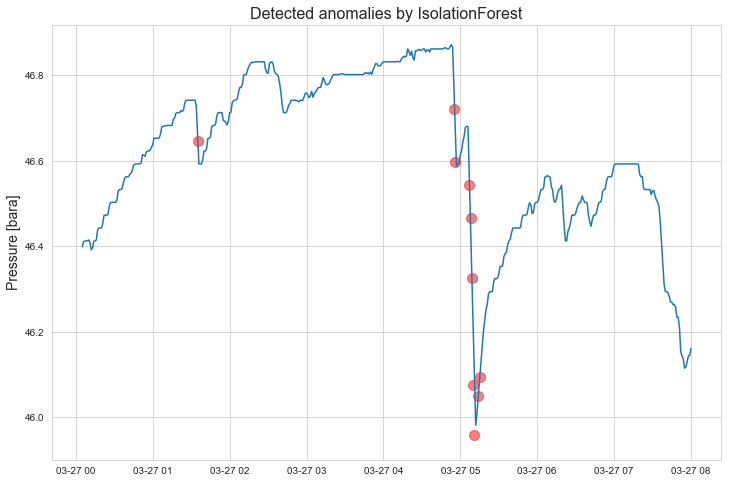

In [251]:
pylab.figure(figsize=(12,8))
pylab.title("Detected anomalies by IsolationForest", size=16)
pylab.plot(data[data['anomaly_by_iforest']==1]['POUT[bara]'])
pylab.scatter(data[data['anomaly_by_iforest']==-1].index,
              data[data['anomaly_by_iforest']==-1]['POUT[bara]'],
              color='r', 
              alpha=0.5,
              s=100
             )
pylab.ylabel("Pressure [bara]", size=14)

----

# Case 2: Well flow rate monitoring

In [562]:
flowrate = pd.read_csv("../data/qo_rate.csv")
flowrate.set_index('Date & Time', inplace=True)
flowrate.index = pd.to_datetime(flowrate.index)

In [563]:
flowrate.head()

,qo_lc[m3/d],qg_lc[m3/d]
Date & Time,,
2018-04-24 00:00:00,335.07,31933.796432
2018-04-24 00:01:00,340.51,38305.953303
2018-04-24 00:02:00,349.76,35991.115830
2018-04-24 00:03:00,314.72,29139.447285
2018-04-24 00:04:00,347.09,35841.065210


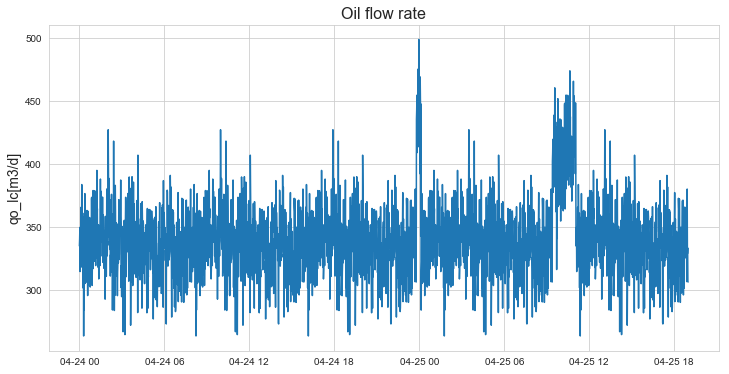

In [568]:
pylab.figure(figsize=(12,6))
pylab.title("Oil flow rate", size=16)
pylab.ylabel('qo_lc[m3/d]', size=14)
pylab.plot(flowrate['qo_lc[m3/d]'])

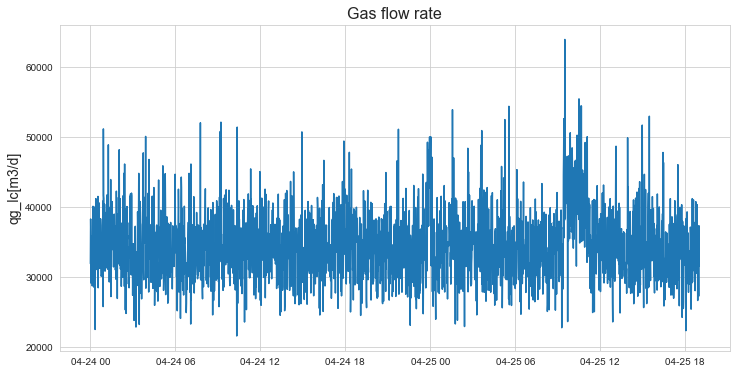

In [570]:
pylab.figure(figsize=(12,6))
pylab.title("Gas flow rate", size=16)
pylab.ylabel('qg_lc[m3/d]', size=14)
pylab.plot(flowrate['qg_lc[m3/d]'])

## Try z-score

## Try LOF

## Try Isolation Forest